In [ ]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt


from google.colab import drive

import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Check for available GPU and set the device for PyTorch
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


# **TON_IOT**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the TON IoT dataset from a CSV file and retrieve its shape
# Ensure the CSV file is located at the specified path
df_TON_IOT = pd.read_csv('/content/drive/MyDrive/train_test_network (1).csv')
shape = df_TON_IOT.shape

In [ ]:
df_TON_IOT.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [ ]:

df_TON_IOT.head()
print('Dataframe shape: ', shape)
print('Number of rows: ', shape[0])
print('Number of columns: ', shape[1])
#df.shape

Dataframe shape:  (211043, 44)
Number of rows:  211043
Number of columns:  44


In [ ]:
df_TON_IOT.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
service,0
duration,0
src_bytes,0
dst_bytes,0
conn_state,0


In [ ]:

df_TON_IOT[df_TON_IOT.duplicated()].shape

(20569, 44)

In [ ]:

# Display the duplicate rows
duplicate_rows = df_TON_IOT[df_TON_IOT.duplicated()]
print(duplicate_rows)


               src_ip  src_port          dst_ip  dst_port proto service  \
21      192.168.1.193     49180    192.168.1.37      8080   tcp       -   
151     192.168.1.193     49194    192.168.1.33      8080   tcp       -   
322     192.168.1.193     49234    192.168.1.37      8080   tcp       -   
330     192.168.1.193     49234    192.168.1.37      8080   tcp       -   
348     192.168.1.193     49236    192.168.1.37      8080   tcp       -   
...               ...       ...             ...       ...   ...     ...   
211032   192.168.1.32     47514  18.194.169.124        80   tcp       -   
211033   192.168.1.32     47518  18.194.169.124        80   tcp       -   
211034   192.168.1.32     47634  18.194.169.124        80   tcp       -   
211035   192.168.1.32     48134  18.194.169.124        80   tcp       -   
211036   192.168.1.32     48156  18.194.169.124        80   tcp       -   

        duration  src_bytes  dst_bytes conn_state  ...  \
21      0.000127          0          0   

In [ ]:
# Remove duplicate rows and keep the first occurrence
df_TON_IOT_cleaned = df_TON_IOT.drop_duplicates()


In [ ]:
df_TON_IOT_cleaned[df_TON_IOT_cleaned.duplicated()].shape

(0, 44)

In [ ]:
df_TON_IOT.shape

(211043, 44)

In [ ]:

df_TON_IOT_cleaned.shape

(190474, 44)

In [ ]:
df_TON_IOT_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  190474 non-null  object 
 1   src_port                190474 non-null  int64  
 2   dst_ip                  190474 non-null  object 
 3   dst_port                190474 non-null  int64  
 4   proto                   190474 non-null  object 
 5   service                 190474 non-null  object 
 6   duration                190474 non-null  float64
 7   src_bytes               190474 non-null  int64  
 8   dst_bytes               190474 non-null  int64  
 9   conn_state              190474 non-null  object 
 10  missed_bytes            190474 non-null  int64  
 11  src_pkts                190474 non-null  int64  
 12  src_ip_bytes            190474 non-null  int64  
 13  dst_pkts                190474 non-null  int64  
 14  dst_ip_bytes            1

In [ ]:
df_TON_IOT_cleaned.shape

(190474, 44)

In [ ]:
# Drop the 'type' column from the cleaned DataFrame
df_TON_IOT_cleaned = df_TON_IOT_cleaned.drop('type', axis = 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Specify the columns to be encoded
columns_to_encode = ['src_ip', 'dst_ip', 'proto', 'service','conn_state','dns_query', 'dns_AA', 'dns_RD','dns_RA','dns_rejected','ssl_version','ssl_cipher','ssl_resumed','ssl_established','ssl_subject','ssl_issuer', 'http_trans_depth', 'http_method','http_uri','http_version','http_user_agent','http_orig_mime_types','http_resp_mime_types','weird_name','weird_addl','weird_notice']
# Iterate through each specified column to apply label encoding
for column in columns_to_encode:
    le = LabelEncoder()
    df_TON_IOT_cleaned[column] = le.fit_transform(df_TON_IOT_cleaned[column])
df_TON_IOT_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190474 entries, 0 to 211042
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  190474 non-null  int64  
 1   src_port                190474 non-null  int64  
 2   dst_ip                  190474 non-null  int64  
 3   dst_port                190474 non-null  int64  
 4   proto                   190474 non-null  int64  
 5   service                 190474 non-null  int64  
 6   duration                190474 non-null  float64
 7   src_bytes               190474 non-null  int64  
 8   dst_bytes               190474 non-null  int64  
 9   conn_state              190474 non-null  int64  
 10  missed_bytes            190474 non-null  int64  
 11  src_pkts                190474 non-null  int64  
 12  src_ip_bytes            190474 non-null  int64  
 13  dst_pkts                190474 non-null  int64  
 14  dst_ip_bytes            1

In [ ]:
df_TON_IOT_cleaned.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label
0,26,4444,201,49178,1,0,290.371539,101568,2592,0,...,0,0,0,0,0,0,0,0,0,1
1,16,49180,210,8080,1,0,0.000102,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,16,49180,210,8080,1,0,0.000148,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,16,49180,210,8080,1,0,0.000113,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,16,49180,210,8080,1,0,0.000130,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Print the count of each class in the 'label' column of the cleaned DataFrame
print(df_TON_IOT_cleaned.groupby("label").size())

label
0     42040
1    148434
dtype: int64


In [ ]:
df=df_TON_IOT_cleaned

In [ ]:
df

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label
0,26,4444,201,49178,1,0,290.371539,101568,2592,0,...,0,0,0,0,0,0,0,0,0,1
1,16,49180,210,8080,1,0,0.000102,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,16,49180,210,8080,1,0,0.000148,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,16,49180,210,8080,1,0,0.000113,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,16,49180,210,8080,1,0,0.000130,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211038,22,48286,164,80,1,5,65.376610,2665,322,9,...,0,0,0,0,0,0,0,0,0,1
211039,22,48288,164,80,1,5,65.710346,1987,322,9,...,0,0,0,0,0,0,0,0,0,1
211040,22,48292,164,80,1,5,65.766512,3922,322,9,...,0,0,0,0,0,0,0,0,0,1
211041,22,48294,164,80,1,5,65.753940,2401,322,9,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Separate the features (X) from the target variable (y)
X_TON_IOT = df_TON_IOT_cleaned.drop('label', axis = 1)  # Features: all columns except 'label'
y_TON_IOT = df_TON_IOT_cleaned['label']# Target variable: the 'label' column
X_TON_IOT.shape, y_TON_IOT.shape

((190474, 42), (190474,))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_TON_IOT_train, X_TON_IOT_test,y_TON_IOT_train, y_TON_IOT_test = train_test_split(X_TON_IOT, y_TON_IOT, test_size=0.4, random_state = 1337
)
# Further split the test set into validation and test sets
# 50% of the original test set will be used for validation and 50% for the final test
X_TON_IOT_valid, X_TON_IOT_test2,y_TON_IOT_valid, y_TON_IOT_test2 = train_test_split(X_TON_IOT_test, y_TON_IOT_test, test_size=0.5, random_state = 1337
)

In [ ]:
from imblearn.combine import SMOTETomek

# Create the SMOTE-TOMEK
smt = SMOTETomek(random_state=42)

# Apply SMOTE-TOMEK to balance the classes
X_TON_IOT_train, y_TON_IOT_train = smt.fit_resample(X_TON_IOT_train, y_TON_IOT_train)


In [ ]:
from imblearn.combine import SMOTETomek
# Apply SMOTE-TOMEK to balance the classes
X_TON_IOT_valid, y_TON_IOT_valid = smt.fit_resample(X_TON_IOT_valid, y_TON_IOT_valid)


In [ ]:
# Concatenate the training features and target variable into a single DataFrame
df1 = pd.concat([X_TON_IOT_train, y_TON_IOT_train], axis=1)


In [ ]:
# Concatenate the validation features and target variable into a single DataFrame
df2 = pd.concat([X_TON_IOT_valid, y_TON_IOT_valid], axis=1)

In [ ]:
# Concatenate the test features and target variable into a single DataFrame
df3 = pd.concat([X_TON_IOT_test2, y_TON_IOT_test2], axis=1)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import random

# Select all columns except "label"
columns_to_concat = [col for col in df1.columns if col not in ['label']]

# Concatenate the selected columns into a single "text" column"
df1['text'] = df1[columns_to_concat].astype(str).agg(' '.join, axis=1)

# Keep only the "label" and "text" columns
df1 = df1[['label' , 'text']]

# Shuffle the data
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)

# Repeat the process for df2
columns_to_concat = [col for col in df2.columns if col not in ['label']]


df2['text'] = df2[columns_to_concat].astype(str).agg(' '.join, axis=1)
df2 = df2[['label' , 'text']]
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

# Repeat the process for df3
columns_to_concat = [col for col in df3.columns if col not in ['label']]
df3['text'] = df3[columns_to_concat].astype(str).agg(' '.join, axis=1)
df3 = df3[['label' , 'text']]
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:

# Save the DataFrames to CSV files
df1.to_csv('train.csv', index=False)
df2.to_csv('val.csv', index=False)
df3.to_csv('test.csv', index=False)

# Display the size of each dataset
print(f'Train set size: {df1.shape[0]}')
print(f'Validation set size: {df2.shape[0]}')
print(f'Test set size: {df3.shape[0]}')


Train set size: 178324
Validation set size: 59142
Test set size: 38095


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare training data
training_texts = df1.text.values # Extract texts from the training DataFrame
training_labels = df1.label.values # Extract labels from the training DataFrame
max_len = 80  # Set the maximum sentence length

input_ids = [] # List to store input IDs
attention_masks = [] # List to store attention masks
# Encode each training text
for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True, # Add special tokens [CLS] and [SEP]
                        max_length=max_len,  # Return attention masks
                        padding='max_length',  # Pad sentences to the maximum length.
                        return_attention_mask=True, # Return attention masks
                        return_tensors='pt', # Return PyTorch tensors
                        truncation=True, # Truncate texts longer than max_length
                   )

    input_ids.append(encoded_dict['input_ids'])  # Store the input IDs
    attention_masks.append(encoded_dict['attention_mask']) # Store the attention masks

input_ids = torch.cat(input_ids, dim=0)  # Concatenate input IDs into a single tensor
attention_masks = torch.cat(attention_masks, dim=0)  # Concatenate attention masks into a single tensor
labels = torch.tensor(training_labels)   # Convert labels to a tensor

# Display original text and its corresponding token IDs
print('Original: ', training_texts[0]) # Print the first training text
print('Token IDs:', input_ids[0]) # Print the token IDs of the first training text


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original:  18 1454 203 1454 1 0 0.2253982889271977 0 0 6 0 120 4800 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Token IDs: tensor([  101,  2324, 13741,  2549, 18540, 13741,  2549,  1015,  1014,  1014,
         1012, 14993, 23499,  2620, 22407,  2620,  2683, 22907, 16147,  2581,
         2581,  1014,  1014,  1020,  1014,  6036, 17295,  2692,  1014,  1014,
         1015,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,
         1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,
         1014,  1014,  1014,  1014,  1014,  1014,  1014,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
# Create a TensorDataset for the training data
train_dataset = TensorDataset(input_ids, attention_masks, labels)

# Prepare validation data
validation_texts = df2.text.values
validation_labels = df2.label.values

input_ids = []
attention_masks = []

for text in validation_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(validation_labels)

validation_dataset = TensorDataset(input_ids, attention_masks, labels)



In [ ]:
batch_size = 32  # Set the batch size
# Create a DataLoader for the training dataset
train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=batch_size
        )
# Create a DataLoader for the validation dataset
validation_dataloader = DataLoader(
            validation_dataset,
            sampler=SequentialSampler(validation_dataset),
            batch_size=batch_size
        )
# Determine the number of unique categories in the labels
number_of_categories = len(df['label'].unique())
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=number_of_categories,
    output_attentions=False,
    output_hidden_states=False,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move the model to the GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Set the number of training epochs
epochs = 1
# Set up the optimizer
optimizer = AdamW(model.parameters(), # Initialize AdamW optimizer with model parameters
                  lr = 5e-5, # Learning rate
                  eps = 1e-8 # Epsilon value for numerical stability
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Entraînement du modèle
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# Function to format elapsed time into a readable format
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Start the training
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time() # Record the start time of the epoch
    total_train_loss = 0
    model.train()
    total_train_accuracy = 0

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Move batch to GPU
        b_input_ids = batch[0].cuda() # Input IDs
        b_input_mask = batch[1].cuda() # Attention mask
        b_labels = batch[2].cuda()  # Labels

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss  # Get the loss
        logits = outputs.logits
        total_train_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        total_train_accuracy += torch.sum(preds == b_labels).item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
 # Calculate average training loss and accuracy
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(df1)
    training_time = format_time(time.time() - t0)  # Calculate training time for the epoch
 # Print training statistics for the epoch
    print("Average training loss: {0:.6f}".format(avg_train_loss))
    print("Training Accuracy: {0:.7f}".format(avg_train_accuracy))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy': avg_train_accuracy,
            'Training Time': training_time,
        }
    )
# Print total training time upon completion
print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Batch    10  of  5,573.    Elapsed: 0:00:06.
Batch    20  of  5,573.    Elapsed: 0:00:10.
Batch    30  of  5,573.    Elapsed: 0:00:14.
Batch    40  of  5,573.    Elapsed: 0:00:18.
Batch    50  of  5,573.    Elapsed: 0:00:23.
Batch    60  of  5,573.    Elapsed: 0:00:27.
Batch    70  of  5,573.    Elapsed: 0:00:32.
Batch    80  of  5,573.    Elapsed: 0:00:36.
Batch    90  of  5,573.    Elapsed: 0:00:41.
Batch   100  of  5,573.    Elapsed: 0:00:45.
Batch   110  of  5,573.    Elapsed: 0:00:49.
Batch   120  of  5,573.    Elapsed: 0:00:54.
Batch   130  of  5,573.    Elapsed: 0:00:58.
Batch   140  of  5,573.    Elapsed: 0:01:02.
Batch   150  of  5,573.    Elapsed: 0:01:06.
Batch   160  of  5,573.    Elapsed: 0:01:11.
Batch   170  of  5,573.    Elapsed: 0:01:15.
Batch   180  of  5,573.    Elapsed: 0:01:19.
Batch   190  of  5,573.    Elapsed: 0:01:23.
Batch   200  of  5,573.    Elapsed: 0:01:28.
Batch   210  of  5,573.    Elapsed: 0:01:32.
Batch   220  of  5,573.  

In [ ]:
 print("Training Accuracy: {0:.7f}".format(avg_train_accuracy))

Training Accuracy: 0.9983121


In [ ]:
# Evaluation of the model
print("Running Validation...")
# Record the start time of validation
t0 = time.time()
model.eval() # Set the model to evaluation mode

val_loss, val_accuracy = 0, 0 # Initialize validation loss and accuracy
nb_val_steps, nb_val_examples = 0, 0 # Initialize counters for validation steps and examples

predictions, true_labels = [], [] # Lists to store predictions and true labels

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch) # Move batch data to the device (GPU)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    val_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)  # Store predictions
    true_labels.append(label_ids) # Store true labels

avg_val_loss = val_loss / len(validation_dataloader)
# Print validation results
print("Validation Loss: {0:.6f}".format(avg_val_loss))
print("Validation completed in {:} (h:mm:ss)".format(format_time(time.time() - t0)))



Running Validation...
Validation Loss: 0.001204
Validation completed in 0:04:17 (h:mm:ss)


Validation Loss: 0.001204
Validation completed in 0:04:17 (h:mm:ss)
Validation Accuracy: 0.999831
Validation F1-Score: 0.999831
Validation Precision: 0.999831
Validation Recall: 0.999831
Validation Classification Report:
              precision    recall  f1-score   support

           0   0.999899  0.999763  0.999831     29571
           1   0.999763  0.999899  0.999831     29571

    accuracy                       0.999831     59142
   macro avg   0.999831  0.999831  0.999831     59142
weighted avg   0.999831  0.999831  0.999831     59142



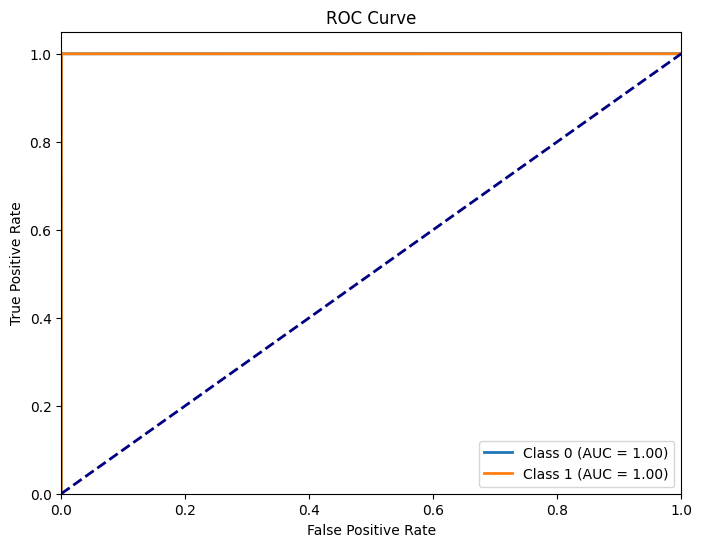

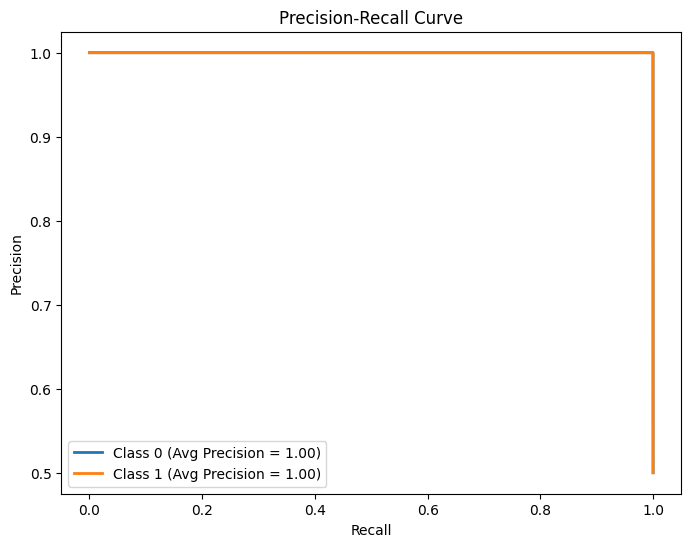

In [ ]:
# Print the average validation loss
print("Validation Loss: {0:.6f}".format(avg_val_loss))
# Calculate validation accuracy
print("Validation completed in {:} (h:mm:ss)".format(format_time(time.time() - t0)))

# Calculate validation accuracy
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)
val_accuracy = np.sum(pred_labels == true_labels) / len(true_labels)
# Print validation accuracy
print("Validation Accuracy: {0:.6f}".format(val_accuracy))

# Calculate classification metrics for validation data
val_f1 = f1_score(true_labels, pred_labels, average='macro')
val_precision = precision_score(true_labels, pred_labels, average='macro')
val_recall = recall_score(true_labels, pred_labels, average='macro')

# Print classification metrics
print("Validation F1-Score: {0:.6f}".format(val_f1))
print("Validation Precision: {0:.6f}".format(val_precision))
print("Validation Recall: {0:.6f}".format(val_recall))

# Generate a classification report
target_names = [str(i) for i in range(number_of_categories)]
val_classification_report = classification_report(true_labels, pred_labels, target_names=target_names, digits=6)
print("Validation Classification Report:")
print(val_classification_report)

# Function to plot ROC curves and calculate AUC for validation data
def plot_roc_curve(true_labels, predictions, num_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, predictions, number_of_categories)

# Function to plot precision-recall curves for validation data
def plot_precision_recall_curve(true_labels, predictions, num_classes):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_labels, predictions[:, i], pos_label=i)
        average_precision[i] = average_precision_score(true_labels, predictions[:, i], pos_label=i)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (Avg Precision = {average_precision[i]:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

plot_precision_recall_curve(true_labels, predictions, number_of_categories)

Validation Confusion Matrix:
[[29564     7]
 [    3 29568]]


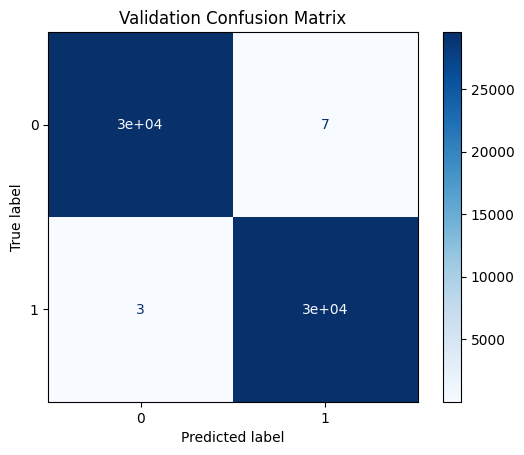

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate and display the confusion matrix for validation data

conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Validation Confusion Matrix:")
print(conf_matrix)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [ ]:
import time


# Preparation of test data
test_texts = df3.text.values
test_labels = df3.label.values

input_ids = []
attention_masks = []


start_time = time.time()

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


end_time = time.time()


elapsed_time = end_time - start_time

print(f"Temps de préparation des données de test: {elapsed_time:.2f} secondes")


Temps de préparation des données de test: 27.64 secondes


In [ ]:

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)

prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Test Loss: 0.000682
Test Accuracy: 0.999895
Test F1-Score: 0.999848
Test Precision: 0.999806
Test Recall: 0.999890
Temps de détection: 166.2459 secondes


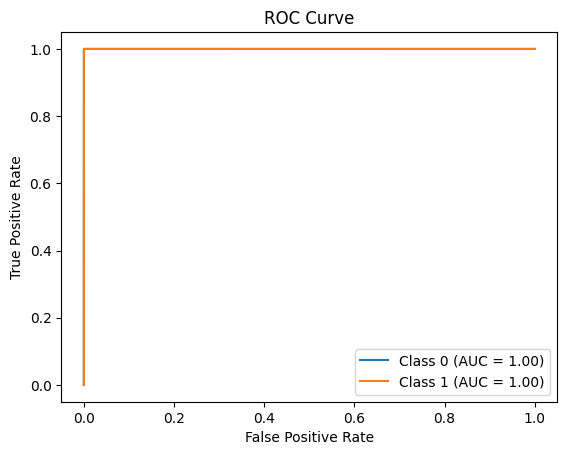

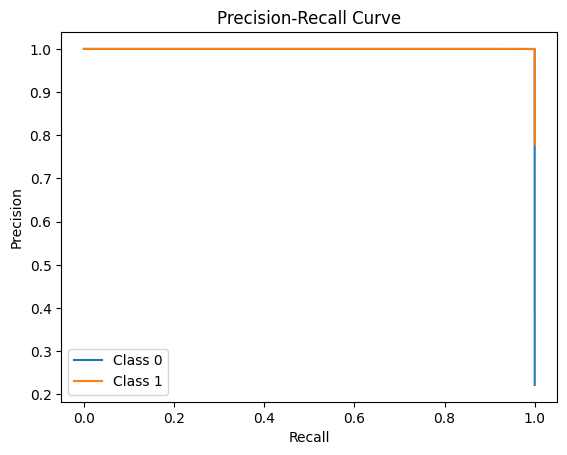

In [ ]:
import time
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(true_labels, predictions, number_of_categories):
     # Plot the ROC curve for each class
    for i in range(number_of_categories):
        fpr, tpr, _ = roc_curve(true_labels == i, predictions[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(true_labels, predictions, number_of_categories):
  # Plot the precision-recall curve for each class
    for i in range(number_of_categories):
        precision, recall, _ = precision_recall_curve(true_labels == i, predictions[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Evaluation on the test data
model.eval()

test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0

predictions, true_labels = [], []

start_time = time.time()

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    test_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

avg_test_loss = test_loss / len(prediction_dataloader)

print("Test Loss: {0:.6f}".format(avg_test_loss))

# Calculate test accuracy
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)
test_accuracy = np.sum(pred_labels == true_labels) / len(true_labels)

print("Test Accuracy: {0:.6f}".format(test_accuracy))

# Calculate classification metrics for the test data
test_f1 = f1_score(true_labels, pred_labels, average='macro')
test_precision = precision_score(true_labels, pred_labels, average='macro')
test_recall = recall_score(true_labels, pred_labels, average='macro')

print("Test F1-Score: {0:.6f}".format(test_f1))
print("Test Precision: {0:.6f}".format(test_precision))
print("Test Recall: {0:.6f}".format(test_recall))


end_time = time.time()
elapsed_time = end_time - start_time  # Display detection time

print(f"Temps de détection: {elapsed_time:.4f} secondes")
# Plot ROC and AUC curves for the test data
plot_roc_curve(true_labels, predictions, number_of_categories)


# Plot precision-recall curves for the test data
plot_precision_recall_curve(true_labels, predictions, number_of_categories)


In [ ]:

target_names = df['label'].unique().astype(str)

# Classification report for the test data
test_classification_report = classification_report(true_labels, pred_labels, target_names=target_names, digits=6)
print("Test Classification Report:")
print(test_classification_report)


Test Classification Report:
              precision    recall  f1-score   support

           1   0.999645  0.999882  0.999763      8454
           0   0.999966  0.999899  0.999933     29641

    accuracy                       0.999895     38095
   macro avg   0.999806  0.999890  0.999848     38095
weighted avg   0.999895  0.999895  0.999895     38095



Test Confusion Matrix:
[[ 8453     1]
 [    3 29638]]


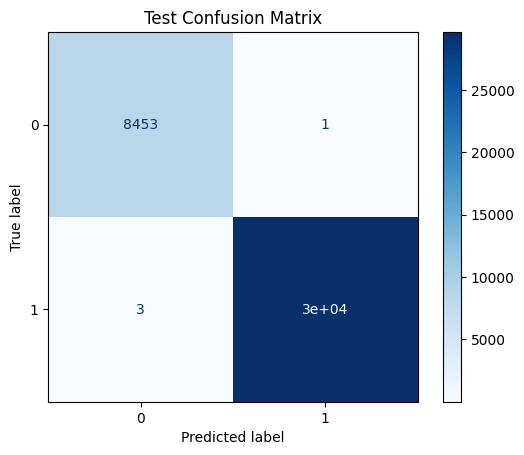

In [ ]:
# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Test Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# **CICIoT2023**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import random


# Load the CICIoT2023 dataset from a CSV file and retrieve its shape
# Ensure the CSV file is located at the specified path
CICIoT2023 = pd.read_csv('/content/drive/MyDrive/part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv', low_memory=False) # Ensure the CSV file is located at the specified path !!




In [ ]:

df_Edge_IIoTset=CICIoT2023

In [ ]:

df_Edge_IIoTset.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,53.46,5.94,63.36,1.145800,1.145800,0.0,0.0,1.0,0.0,...,0.040218,54.06,8.309402e+07,9.5,10.393232,0.057331,0.054789,0.03,141.55,DDoS-SYN_Flood
1,0.000000,54.00,6.00,64.00,1.027823,1.027823,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307159e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood
2,2.204616,93.96,6.00,64.00,0.671213,0.671213,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336561e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
3,0.053618,12497.00,17.00,64.00,47647.897124,47647.897124,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.310693e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
4,0.000000,0.00,1.00,64.00,0.667744,0.667744,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.314933e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood


In [ ]:
print(df_Edge_IIoTset.groupby("label").size())

label
Backdoor_Malware              18
BenignTraffic               5200
BrowserHijacking              30
CommandInjection              26
DDoS-ACK_Fragmentation      1384
DDoS-HTTP_Flood              127
DDoS-ICMP_Flood            33529
DDoS-ICMP_Fragmentation     2132
DDoS-PSHACK_Flood          19373
DDoS-RSTFINFlood           19032
DDoS-SYN_Flood             19235
DDoS-SlowLoris               100
DDoS-SynonymousIP_Flood    16798
DDoS-TCP_Flood             20964
DDoS-UDP_Flood             25343
DDoS-UDP_Fragmentation      1392
DNS_Spoofing                 827
DictionaryBruteForce          57
DoS-HTTP_Flood               347
DoS-SYN_Flood               9314
DoS-TCP_Flood              12326
DoS-UDP_Flood              15500
MITM-ArpSpoofing            1432
Mirai-greeth_flood          4728
Mirai-greip_flood           3606
Mirai-udpplain              4308
Recon-HostDiscovery          652
Recon-OSScan                 425
Recon-PingSweep               10
Recon-PortScan               399
SqlI

In [ ]:
print(df_Edge_IIoTset.groupby("label").size())

label
Backdoor_Malware              18
BenignTraffic               5200
BrowserHijacking              30
CommandInjection              26
DDoS-ACK_Fragmentation      1384
DDoS-HTTP_Flood              127
DDoS-ICMP_Flood            33529
DDoS-ICMP_Fragmentation     2132
DDoS-PSHACK_Flood          19373
DDoS-RSTFINFlood           19032
DDoS-SYN_Flood             19235
DDoS-SlowLoris               100
DDoS-SynonymousIP_Flood    16798
DDoS-TCP_Flood             20964
DDoS-UDP_Flood             25343
DDoS-UDP_Fragmentation      1392
DNS_Spoofing                 827
DictionaryBruteForce          57
DoS-HTTP_Flood               347
DoS-SYN_Flood               9314
DoS-TCP_Flood              12326
DoS-UDP_Flood              15500
MITM-ArpSpoofing            1432
Mirai-greeth_flood          4728
Mirai-greip_flood           3606
Mirai-udpplain              4308
Recon-HostDiscovery          652
Recon-OSScan                 425
Recon-PingSweep               10
Recon-PortScan               399
SqlI

In [ ]:
import pandas as pd

# Create a new column 'label2' where 'BenignTraffic' is mapped to 0 and all other labels to 1
df_Edge_IIoTset['label2'] = df_Edge_IIoTset['label'].apply(lambda x: 0 if x == "BenignTraffic" else 1)

# Display the first few rows of the DataFrame to verify the changes
print(df_Edge_IIoTset.head())


   flow_duration  Header_Length  Protocol Type  Duration          Rate  \
0       0.000000          53.46           5.94     63.36      1.145800   
1       0.000000          54.00           6.00     64.00      1.027823   
2       2.204616          93.96           6.00     64.00      0.671213   
3       0.053618       12497.00          17.00     64.00  47647.897124   
4       0.000000           0.00           1.00     64.00      0.667744   

          Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0      1.145800    0.0              0.0              1.0              0.0   
1      1.027823    0.0              0.0              0.0              0.0   
2      0.671213    0.0              0.0              1.0              0.0   
3  47647.897124    0.0              0.0              0.0              0.0   
4      0.667744    0.0              0.0              0.0              0.0   

   ...  Tot size           IAT  Number   Magnitue    Radius  Covariance  \
0  ...     54.06 

In [ ]:
df_Edge_IIoTset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218805 entries, 0 to 218804
Data columns (total 48 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    218805 non-null  float64
 1   Header_Length    218805 non-null  float64
 2   Protocol Type    218805 non-null  float64
 3   Duration         218805 non-null  float64
 4   Rate             218805 non-null  float64
 5   Srate            218805 non-null  float64
 6   Drate            218805 non-null  float64
 7   fin_flag_number  218805 non-null  float64
 8   syn_flag_number  218805 non-null  float64
 9   rst_flag_number  218805 non-null  float64
 10  psh_flag_number  218805 non-null  float64
 11  ack_flag_number  218805 non-null  float64
 12  ece_flag_number  218805 non-null  float64
 13  cwr_flag_number  218805 non-null  float64
 14  ack_count        218805 non-null  float64
 15  syn_count        218805 non-null  float64
 16  fin_count        218805 non-null  floa

In [ ]:

df_Edge_IIoTset.isnull().sum()

In [ ]:
import pandas as pd

# Adjust display settings to show all columns
pd.set_option('display.max_rows', None)

# Count the number of null values in each column
null_counts = df_Edge_IIoTset.isnull().sum()

# Print the null counts for each column
print(null_counts)

# Reset the display settings if needed
pd.reset_option('display.max_rows')


In [ ]:
df_Edge_IIoTset[df_Edge_IIoTset.duplicated()].shape

(0, 48)

In [ ]:
# Display the duplicate rows
duplicate_rows = df_Edge_IIoTset[df_Edge_IIoTset.duplicated()]
print(duplicate_rows)


Empty DataFrame
Columns: [flow_duration, Header_Length, Protocol Type, Duration, Rate, Srate, Drate, fin_flag_number, syn_flag_number, rst_flag_number, psh_flag_number, ack_flag_number, ece_flag_number, cwr_flag_number, ack_count, syn_count, fin_count, urg_count, rst_count, HTTP, HTTPS, DNS, Telnet, SMTP, SSH, IRC, TCP, UDP, DHCP, ARP, ICMP, IPv, LLC, Tot sum, Min, Max, AVG, Std, Tot size, IAT, Number, Magnitue, Radius, Covariance, Variance, Weight, label, label2]
Index: []

[0 rows x 48 columns]


In [ ]:

# Remove duplicate rows and keep the first occurrence
df_Edge_IIoTset_cleaned = df_Edge_IIoTset.drop_duplicates()


In [ ]:
df_Edge_IIoTset_cleaned[df_Edge_IIoTset_cleaned.duplicated()].shape

(0, 48)

In [ ]:

df_Edge_IIoTset_cleaned.shape

(218805, 48)

In [ ]:

df_Edge_IIoTset_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218805 entries, 0 to 218804
Data columns (total 48 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    218805 non-null  float64
 1   Header_Length    218805 non-null  float64
 2   Protocol Type    218805 non-null  float64
 3   Duration         218805 non-null  float64
 4   Rate             218805 non-null  float64
 5   Srate            218805 non-null  float64
 6   Drate            218805 non-null  float64
 7   fin_flag_number  218805 non-null  float64
 8   syn_flag_number  218805 non-null  float64
 9   rst_flag_number  218805 non-null  float64
 10  psh_flag_number  218805 non-null  float64
 11  ack_flag_number  218805 non-null  float64
 12  ece_flag_number  218805 non-null  float64
 13  cwr_flag_number  218805 non-null  float64
 14  ack_count        218805 non-null  float64
 15  syn_count        218805 non-null  float64
 16  fin_count        218805 non-null  floa

In [ ]:
df_Edge_IIoTset_cleaned.shape

(218805, 48)

In [ ]:

df_Edge_IIoTset_cleaned = df_Edge_IIoTset_cleaned.drop('label', axis = 1)

In [ ]:
df_Edge_IIoTset_cleaned.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label2
0,0.000000,53.46,5.94,63.36,1.145800,1.145800,0.0,0.0,1.0,0.0,...,0.040218,54.06,8.309402e+07,9.5,10.393232,0.057331,0.054789,0.03,141.55,1
1,0.000000,54.00,6.00,64.00,1.027823,1.027823,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307159e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
2,2.204616,93.96,6.00,64.00,0.671213,0.671213,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336561e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
3,0.053618,12497.00,17.00,64.00,47647.897124,47647.897124,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.310693e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,1
4,0.000000,0.00,1.00,64.00,0.667744,0.667744,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.314933e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,1


In [ ]:
df = df_Edge_IIoTset_cleaned

In [ ]:
print(df_Edge_IIoTset_cleaned.groupby("label2").size())

label2
0      5200
1    213605
dtype: int64


In [ ]:
X_TON_IOT = df_Edge_IIoTset_cleaned.drop('label2', axis = 1)
y_TON_IOT = df_Edge_IIoTset_cleaned['label2']
X_TON_IOT.shape, y_TON_IOT.shape

((218805, 46), (218805,))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
X_TON_IOT_train, X_TON_IOT_test,y_TON_IOT_train, y_TON_IOT_test = train_test_split(X_TON_IOT, y_TON_IOT, test_size=0.4, random_state = 1337
)
X_TON_IOT_valid, X_TON_IOT_test2,y_TON_IOT_valid, y_TON_IOT_test2 = train_test_split(X_TON_IOT_test, y_TON_IOT_test, test_size=0.5, random_state = 1337
)

In [ ]:
from imblearn.combine import SMOTETomek


smt = SMOTETomek(random_state=42)
X_TON_IOT_train, y_TON_IOT_train = smt.fit_resample(X_TON_IOT_train, y_TON_IOT_train)


In [ ]:
from imblearn.combine import SMOTETomek

X_TON_IOT_valid, y_TON_IOT_valid = smt.fit_resample(X_TON_IOT_valid, y_TON_IOT_valid)


In [ ]:
y_TON_IOT_train.value_counts()

label2
1    128002
0    128002
Name: count, dtype: int64

In [ ]:
y_TON_IOT.value_counts()

label2
1    213605
0      5200
Name: count, dtype: int64

In [ ]:
train_df = pd.concat([X_TON_IOT_train, y_TON_IOT_train], axis=1)
val_df = pd.concat([X_TON_IOT_valid, y_TON_IOT_valid], axis=1)
test_df = pd.concat([X_TON_IOT_test2, y_TON_IOT_test2], axis=1)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import random


columns_to_concat = [col for col in train_df.columns if col not in [ 'label2']]

train_df['text'] = train_df[columns_to_concat].astype(str).agg(' '.join, axis=1)

train_df = train_df[[ 'label2', 'text']]

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in val_df.columns if col not in [ 'label2']]

val_df['text'] = val_df[columns_to_concat].astype(str).agg(' '.join, axis=1)

val_df = val_df[['label2', 'text']]

val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in df.columns if col not in ['label2']]

test_df['text'] = test_df[columns_to_concat].astype(str).agg(' '.join, axis=1)

test_df = test_df[[ 'label2', 'text']]

test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)



train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)


print(f'Train set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')





Train set size: 256004
Validation set size: 85348
Test set size: 43761


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


training_texts = train_df.text.values
training_labels = train_df.label2.values
max_len = 80  # Set the maximum sentence length.

input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',  # Pad sentences to the maximum length.
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original:  35.40903648879965 2968411.785574215 5.7891248436314235 119.74161220939718 81.64296550678492 81.64296550678492 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.297082812104744 0.0 105.61801751328059 2813.9588141111167 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 5433.864087048338 910.9682852110825 1005.0879559638346 995.6759888885595 28.235901225825614 910.9682852110825 0.002289647306239745 5.5 39.54862586590061 39.93159445938968 12238.308114705134 0.1 38.5
Token IDs: tensor([  101,  3486,  1012,  2871, 21057, 21619, 18139,  2620,  2581,  2683,
         2683, 26187, 27200,  2620, 23632,  2487,  1012,  6275, 24087,  2581,
        20958, 16068,  1019,  1012,  6275,  2683, 12521, 18139, 23777,  2575,
        21486, 20958, 19481, 13285,  1012,  6356, 16048, 12521, 11387,  2683,
        23499,  2581, 15136,  6282,  1012,  4185, 24594, 26187, 12376,  2575,
         2581,  2620, 26224,  2475,  6282,  1012,  4185, 24594, 26187, 12376,
         2575,  2581,  2620, 26224,  2475,  1014,

In [ ]:

train_dataset = TensorDataset(input_ids, attention_masks, labels)


validation_texts = val_df.text.values
validation_labels = val_df.label2.values

input_ids = []
attention_masks = []

for text in validation_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(validation_labels)

validation_dataset = TensorDataset(input_ids, attention_masks, labels)



In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=batch_size
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler=SequentialSampler(validation_dataset),
            batch_size=batch_size
        )

number_of_categories = len(df['label2'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=number_of_categories,
    output_attentions=False,
    output_hidden_states=False,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
epochs = 1

epochs = 1

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()
    total_train_accuracy = 0

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Move batch to GPU
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        total_train_accuracy += torch.sum(preds == b_labels).item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_df)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.6f}".format(avg_train_loss))
    print("Training Accuracy: {0:.7f}".format(avg_train_accuracy))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy': avg_train_accuracy,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Batch    10  of  8,001.    Elapsed: 0:00:05.
Batch    20  of  8,001.    Elapsed: 0:00:10.
Batch    30  of  8,001.    Elapsed: 0:00:14.
Batch    40  of  8,001.    Elapsed: 0:00:18.
Batch    50  of  8,001.    Elapsed: 0:00:22.
Batch    60  of  8,001.    Elapsed: 0:00:27.
Batch    70  of  8,001.    Elapsed: 0:00:31.
Batch    80  of  8,001.    Elapsed: 0:00:35.
Batch    90  of  8,001.    Elapsed: 0:00:40.
Batch   100  of  8,001.    Elapsed: 0:00:44.
Batch   110  of  8,001.    Elapsed: 0:00:48.
Batch   120  of  8,001.    Elapsed: 0:00:52.
Batch   130  of  8,001.    Elapsed: 0:00:56.
Batch   140  of  8,001.    Elapsed: 0:01:00.
Batch   150  of  8,001.    Elapsed: 0:01:05.
Batch   160  of  8,001.    Elapsed: 0:01:09.
Batch   170  of  8,001.    Elapsed: 0:01:13.
Batch   180  of  8,001.    Elapsed: 0:01:17.
Batch   190  of  8,001.    Elapsed: 0:01:21.
Batch   200  of  8,001.    Elapsed: 0:01:25.
Batch   210  of  8,001.    Elapsed: 0:01:29.
Batch   220  of  8,001.  

In [ ]:

print("Running Validation...")

t0 = time.time()
model.eval()

val_loss, val_accuracy = 0, 0
nb_val_steps, nb_val_examples = 0, 0

predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    val_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

avg_val_loss = val_loss / len(validation_dataloader)

print("Validation Loss: {0:.6f}".format(avg_val_loss))
print("Validation completed in {:} (h:mm:ss)".format(format_time(time.time() - t0)))



Running Validation...
Validation Loss: 0.012801
Validation completed in 0:05:29 (h:mm:ss)


In [ ]:



predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)
val_accuracy = np.sum(pred_labels == true_labels) / len(true_labels)

print("Validation Accuracy: {0:.6f}".format(val_accuracy))



Validation Accuracy: 0.994552


Validation F1-Score: 0.994552
Validation Precision: 0.994552
Validation Recall: 0.994552
Validation Classification Report:
              precision    recall  f1-score   support

           0   0.994355  0.994751  0.994553     42674
           1   0.994749  0.994353  0.994551     42674

    accuracy                       0.994552     85348
   macro avg   0.994552  0.994552  0.994552     85348
weighted avg   0.994552  0.994552  0.994552     85348



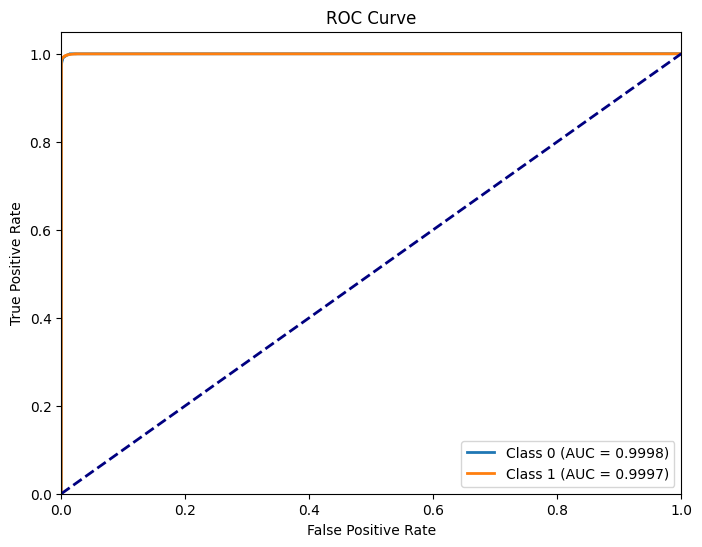

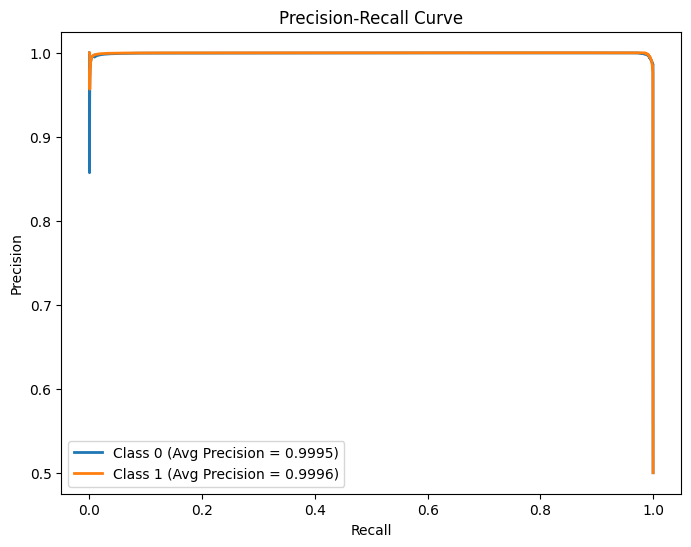

In [ ]:

val_f1 = f1_score(true_labels, pred_labels, average='macro')
val_precision = precision_score(true_labels, pred_labels, average='macro')
val_recall = recall_score(true_labels, pred_labels, average='macro')

print("Validation F1-Score: {0:.6f}".format(val_f1))
print("Validation Precision: {0:.6f}".format(val_precision))
print("Validation Recall: {0:.6f}".format(val_recall))

target_names = [str(i) for i in range(number_of_categories)]
val_classification_report = classification_report(true_labels, pred_labels, target_names=target_names, digits=6)
print("Validation Classification Report:")
print(val_classification_report)


def plot_roc_curve(true_labels, predictions, num_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, predictions, number_of_categories)


def plot_precision_recall_curve(true_labels, predictions, num_classes):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_labels, predictions[:, i], pos_label=i)
        average_precision[i] = average_precision_score(true_labels, predictions[:, i], pos_label=i)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (Avg Precision = {average_precision[i]:.4f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

plot_precision_recall_curve(true_labels, predictions, number_of_categories)

Validation Confusion Matrix:
[[42450   224]
 [  241 42433]]


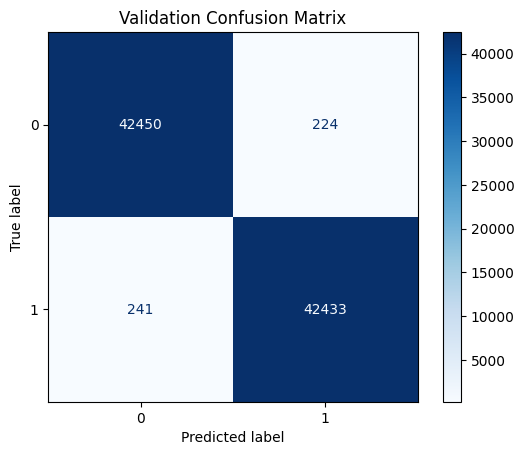

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix for validation predictions
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Validation Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [ ]:
# Prepare the test data
test_texts = test_df.text.values
test_labels = test_df.label2.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Test Loss: 0.026075
Test Accuracy: 0.989351
Test F1-Score: 0.880308
Test Precision: 0.874078
Test Recall: 0.886762
Temps de prédiction: 171.9874 secondes


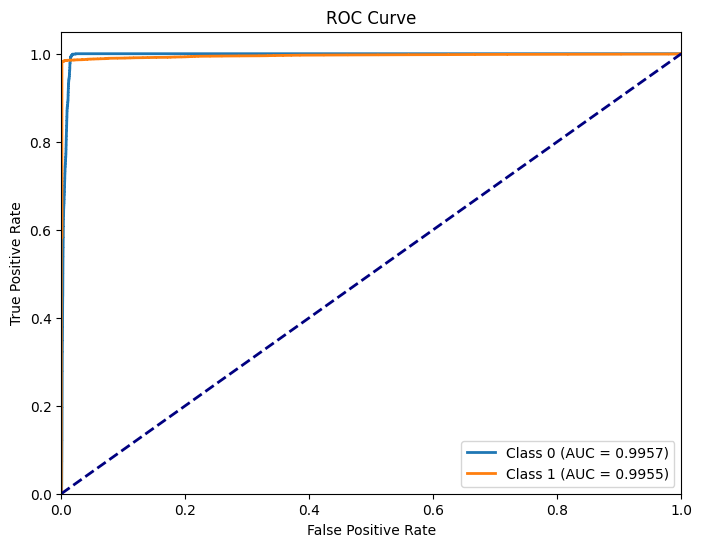

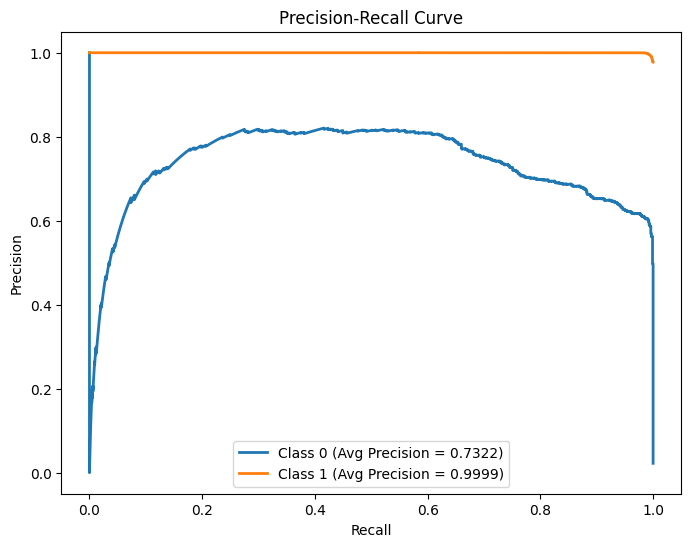

In [ ]:
import time
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

model.eval()

test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0

predictions, true_labels = [], []


start_time = time.time()

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    test_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)


end_time = time.time()

avg_test_loss = test_loss / len(prediction_dataloader)

print("Test Loss: {0:.6f}".format(avg_test_loss))

# Calculate test accuracy
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)
test_accuracy = np.sum(pred_labels == true_labels) / len(true_labels)

print("Test Accuracy: {0:.6f}".format(test_accuracy))


test_f1 = f1_score(true_labels, pred_labels, average='macro')
test_precision = precision_score(true_labels, pred_labels, average='macro')
test_recall = recall_score(true_labels, pred_labels, average='macro')

print("Test F1-Score: {0:.6f}".format(test_f1))
print("Test Precision: {0:.6f}".format(test_precision))
print("Test Recall: {0:.6f}".format(test_recall))
prediction_time = end_time - start_time
print("Temps de prédiction: {0:.4f} secondes".format(prediction_time))
plot_roc_curve(true_labels, predictions, number_of_categories)
plot_precision_recall_curve(true_labels, predictions, number_of_categories)


# **X-IIoTID**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import random

# Load the X-IIoTID dataset from a CSV file and retrieve its shape
# Ensure the CSV file is located at the specified path
XIIoTID = pd.read_csv('/content/drive/MyDrive/X-IIoTID dataset.csv', low_memory=False)

# Print the shape of the DataFrame
shape = df_Edge_IIoTset.shape
print(shape)





(820834, 68)


In [ ]:
df_Edge_IIoTset=XIIoTID

In [ ]:
df_Edge_IIoTset.head()

,Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,...,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,class1,class2,class3
0,9/01/2020,1578540956,192.168.2.199,49278,192.168.2.10,80,tcp,http,0.67369,13437,...,5,0,0,0,0,0,0,Scanning_vulnerability,Reconnaissance,Attack
1,13/01/2020,1578871873,10.0.1.5,39769,131.236.3.92,53,udp,dns,0.000083,78,...,0,0,0,0,0,0,0,Normal,Normal,Normal
2,9/01/2020,1578522486,172.24.1.80,59050,172.24.1.1,53,udp,dns,0.000132,38,...,0,0,0,0,0,0,0,Normal,Normal,Normal
3,27/02/2020,1582757640,192.168.2.196,37966,192.168.2.10,1880,tcp,websocket,9.378481,1121,...,0,1,1,1,1,1,1,Normal,Normal,Normal
4,16/12/2019,1576452612,172.24.1.80,38233,172.24.1.1,53,udp,dns,0.000074,-,...,0,0,0,0,0,0,0,Normal,Normal,Normal


In [ ]:
df_Edge_IIoTset['label'] = df_Edge_IIoTset['class3']=="Attack"
df_Edge_IIoTset['label']=df_Edge_IIoTset['label'].astype('int')

In [ ]:
df_Edge_IIoTset.head()

,Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,...,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,class1,class2,class3,label
0,9/01/2020,1578540956,192.168.2.199,49278,192.168.2.10,80,tcp,http,0.67369,13437,...,0,0,0,0,0,0,Scanning_vulnerability,Reconnaissance,Attack,1
1,13/01/2020,1578871873,10.0.1.5,39769,131.236.3.92,53,udp,dns,0.000083,78,...,0,0,0,0,0,0,Normal,Normal,Normal,0
2,9/01/2020,1578522486,172.24.1.80,59050,172.24.1.1,53,udp,dns,0.000132,38,...,0,0,0,0,0,0,Normal,Normal,Normal,0
3,27/02/2020,1582757640,192.168.2.196,37966,192.168.2.10,1880,tcp,websocket,9.378481,1121,...,1,1,1,1,1,1,Normal,Normal,Normal,0
4,16/12/2019,1576452612,172.24.1.80,38233,172.24.1.1,53,udp,dns,0.000074,-,...,0,0,0,0,0,0,Normal,Normal,Normal,0


In [ ]:
df_Edge_IIoTset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820834 entries, 0 to 820833
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         820503 non-null  object
 1   Timestamp                    820537 non-null  object
 2   Scr_IP                       820834 non-null  object
 3   Scr_port                     820834 non-null  object
 4   Des_IP                       820834 non-null  object
 5   Des_port                     820834 non-null  object
 6   Protocol                     820834 non-null  object
 7   Service                      820834 non-null  object
 8   Duration                     820834 non-null  object
 9   Scr_bytes                    820834 non-null  object
 10  Des_bytes                    820834 non-null  object
 11  Conn_state                   820834 non-null  int64 
 12  missed_bytes                 820834 non-null  object
 13  is_syn_only   

In [ ]:
df_Edge_IIoTset.head()
print('Dataframe shape: ', shape)
print('Number of rows: ', shape[0])
print('Number of columns: ', shape[1])
#df.shape

Dataframe shape:  (820834, 68)
Number of rows:  820834
Number of columns:  68


In [ ]:
df_Edge_IIoTset.isnull().sum()

,0
Date,331
Timestamp,297
Scr_IP,0
Scr_port,0
Des_IP,0
...,...
is_privileged,0
class1,0
class2,0
class3,0


In [ ]:
import pandas as pd

# Adjust display settings to show all columns
pd.set_option('display.max_rows', None)

# Count the number of null values in each column
null_counts = df_Edge_IIoTset.isnull().sum()

# Print the null counts for each column
print(null_counts)

# Reset the display settings if needed
pd.reset_option('display.max_rows')



Date                           331
Timestamp                      297
Scr_IP                           0
Scr_port                         0
Des_IP                           0
Des_port                         0
Protocol                         0
Service                          0
Duration                         0
Scr_bytes                        0
Des_bytes                        0
Conn_state                       0
missed_bytes                     0
is_syn_only                      0
Is_SYN_ACK                       0
is_pure_ack                      0
is_with_payload                  0
FIN or RST                       0
Bad_checksum                     0
is_SYN_with_RST                  0
Scr_pkts                         0
Scr_ip_bytes                     0
Des_pkts                         0
Des_ip_bytes                     0
anomaly_alert                    0
total_bytes                      0
total_packet                     0
paket_rate                       0
byte_rate           

In [ ]:
df_Edge_IIoTset[df_Edge_IIoTset.duplicated()].shape

(6222, 69)

In [ ]:
# Display the duplicate rows
duplicate_rows = df_Edge_IIoTset[df_Edge_IIoTset.duplicated()]
print(duplicate_rows)


              Date   Timestamp          Scr_IP Scr_port         Des_IP  \
5591    21/01/2020  1579585116  192.168.10.155    50192   192.168.2.10   
5630    22/01/2020  1579642499        10.0.1.5    47366   129.94.0.197   
14297   22/01/2020  1579646142    172.24.1.213    51975     172.24.1.1   
15801   10/02/2020  1580966999    172.24.1.100     5353    224.0.0.251   
17484   21/01/2020  1579571748  192.168.10.155    44790   192.168.2.10   
...            ...         ...             ...      ...            ...   
820582  21/01/2020  1579570754    192.168.2.10    56610  192.168.2.199   
820623  21/01/2020  1579572659  192.168.10.153    53437   192.168.2.10   
820641  21/01/2020  1579572094    192.168.2.10    33124  192.168.2.199   
820771  21/01/2020  1579570246    192.168.2.10    54714  192.168.2.199   
820823  21/01/2020  1579586256   192.168.2.196    45356   192.168.2.10   

       Des_port Protocol    Service  Duration Scr_bytes  ... Login_attempt  \
5591         80      tcp       ht

In [ ]:
# Remove duplicate rows and keep the first occurrence
df_Edge_IIoTset_cleaned = df_Edge_IIoTset.drop_duplicates()


In [ ]:
df_Edge_IIoTset_cleaned[df_Edge_IIoTset_cleaned.duplicated()].shape

(0, 69)

In [ ]:
df_Edge_IIoTset_cleaned.shape

(814612, 69)

In [ ]:

df_Edge_IIoTset_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814612 entries, 0 to 820833
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         814281 non-null  object
 1   Timestamp                    814315 non-null  object
 2   Scr_IP                       814612 non-null  object
 3   Scr_port                     814612 non-null  object
 4   Des_IP                       814612 non-null  object
 5   Des_port                     814612 non-null  object
 6   Protocol                     814612 non-null  object
 7   Service                      814612 non-null  object
 8   Duration                     814612 non-null  object
 9   Scr_bytes                    814612 non-null  object
 10  Des_bytes                    814612 non-null  object
 11  Conn_state                   814612 non-null  int64 
 12  missed_bytes                 814612 non-null  object
 13  is_syn_only        

In [ ]:
df_Edge_IIoTset_cleaned.shape

(814612, 69)

In [ ]:
df_Edge_IIoTset_cleaned = df_Edge_IIoTset_cleaned.drop('class1', axis = 1)

In [ ]:
df_Edge_IIoTset_cleaned = df_Edge_IIoTset_cleaned.drop('class3', axis = 1)

In [ ]:
df_Edge_IIoTset_cleaned = df_Edge_IIoTset_cleaned.drop('class2', axis = 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ['Date', 'Timestamp','is_with_payload','is_with_payload','is_pure_ack' ,'FIN or RST','is_SYN_with_RST','Bad_checksum','Scr_IP','is_syn_only','Is_SYN_ACK','Scr_port', 'Des_IP', 'Des_port', 'Protocol', 'Service', 'Duration', 'Scr_bytes', 'Des_bytes', 'missed_bytes', 'Scr_pkts', 'Scr_ip_bytes', 'Des_pkts', 'Des_ip_bytes', 'anomaly_alert', 'total_bytes', 'total_packet', 'paket_rate', 'byte_rate', 'Scr_packts_ratio', 'Des_pkts_ratio', 'Scr_bytes_ratio', 'Des_bytes_ratio', 'Avg_user_time', 'Std_user_time', 'Avg_nice_time', 'Std_nice_time', 'Avg_system_time', 'Std_system_time', 'Avg_iowait_time', 'Std_iowait_time', 'Avg_ideal_time', 'Std_ideal_time', 'Avg_tps', 'Std_tps', 'Avg_rtps', 'Std_rtps', 'Avg_wtps', 'Std_wtps', 'Avg_ldavg_1', 'Std_ldavg_1', 'Avg_kbmemused', 'Std_kbmemused', 'Avg_num_Proc/s', 'Std_num_proc/s', 'Avg_num_cswch/s', 'std_num_cswch/s']

for column in columns_to_encode:
    le = LabelEncoder()
    df_Edge_IIoTset_cleaned[column] = le.fit_transform(df_Edge_IIoTset_cleaned[column])
df_Edge_IIoTset_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814612 entries, 0 to 820833
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Date                         814612 non-null  int64
 1   Timestamp                    814612 non-null  int64
 2   Scr_IP                       814612 non-null  int64
 3   Scr_port                     814612 non-null  int64
 4   Des_IP                       814612 non-null  int64
 5   Des_port                     814612 non-null  int64
 6   Protocol                     814612 non-null  int64
 7   Service                      814612 non-null  int64
 8   Duration                     814612 non-null  int64
 9   Scr_bytes                    814612 non-null  int64
 10  Des_bytes                    814612 non-null  int64
 11  Conn_state                   814612 non-null  int64
 12  missed_bytes                 814612 non-null  int64
 13  is_syn_only                  81461

In [ ]:
df_Edge_IIoTset_cleaned.head()

,Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,...,std_num_cswch/s,OSSEC_alert,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,label
0,47,30649,25,37284,63,6020,2,4,88457,2112,...,4088,1,5,0,0,0,0,0,0,1
1,5,36769,2,27007,12,4973,3,2,83,19237,...,17287,0,0,0,0,0,0,0,0,0
2,47,24817,16,47837,51,4973,3,2,132,12458,...,26013,0,0,0,0,0,0,0,0,0
3,32,182036,24,25062,63,1192,2,16,324051,779,...,46137,0,0,1,1,1,1,1,1,0
4,11,3824,16,25352,51,4973,3,2,74,0,...,34894,0,0,0,0,0,0,0,0,0


In [ ]:
print(df_Edge_IIoTset_cleaned.groupby("label").size())

label
0    418253
1    396359
dtype: int64


In [ ]:
df_Edge_IIoTset_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814612 entries, 0 to 820833
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Date                         814612 non-null  int64
 1   Timestamp                    814612 non-null  int64
 2   Scr_IP                       814612 non-null  int64
 3   Scr_port                     814612 non-null  int64
 4   Des_IP                       814612 non-null  int64
 5   Des_port                     814612 non-null  int64
 6   Protocol                     814612 non-null  int64
 7   Service                      814612 non-null  int64
 8   Duration                     814612 non-null  int64
 9   Scr_bytes                    814612 non-null  int64
 10  Des_bytes                    814612 non-null  int64
 11  Conn_state                   814612 non-null  int64
 12  missed_bytes                 814612 non-null  int64
 13  is_syn_only                  81461

In [ ]:
X_TON_IOT = df_Edge_IIoTset_cleaned.drop('label', axis = 1)
y_TON_IOT = df_Edge_IIoTset_cleaned['label']
X_TON_IOT.shape, y_TON_IOT.shape

((814612, 65), (814612,))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
X_TON_IOT_train, X_TON_IOT_test,y_TON_IOT_train, y_TON_IOT_test = train_test_split(X_TON_IOT, y_TON_IOT, test_size=0.4, random_state = 1337
)
X_TON_IOT_valid, X_TON_IOT_test2,y_TON_IOT_valid, y_TON_IOT_test2 = train_test_split(X_TON_IOT_test, y_TON_IOT_test, test_size=0.5, random_state = 1337
)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=42)
X_TON_IOT_train, y_TON_IOT_train = rus.fit_resample(X_TON_IOT_train, y_TON_IOT_train)


In [ ]:

from imblearn.combine import SMOTETomek
X_TON_IOT_valid, y_TON_IOT_valid = rus.fit_resample(X_TON_IOT_valid, y_TON_IOT_valid)


In [ ]:
y_TON_IOT_train.value_counts()

,count
label,
0,238119
1,238119


In [ ]:
y_TON_IOT_test2.value_counts()

,count
label,
0,83812
1,79111


In [ ]:
train_df = pd.concat([X_TON_IOT_train, y_TON_IOT_train], axis=1)
val_df = pd.concat([X_TON_IOT_valid,y_TON_IOT_valid ], axis=1)
test_df = pd.concat([X_TON_IOT_test2, y_TON_IOT_test2], axis=1)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import random


columns_to_concat = [col for col in train_df.columns if col not in [ 'label']]

train_df['text'] = train_df[columns_to_concat].astype(str).agg(' '.join, axis=1)


train_df = train_df[[ 'label', 'text']]

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in val_df.columns if col not in [ 'label']]

val_df['text'] = val_df[columns_to_concat].astype(str).agg(' '.join, axis=1)

val_df = val_df[['label', 'text']]

val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_concat = [col for col in test_df.columns if col not in ['label']]

test_df['text'] = test_df[columns_to_concat].astype(str).agg(' '.join, axis=1)

test_df = test_df[[ 'label', 'text']]

test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)



train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)


print(f'Train set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')





Train set size: 476238
Validation set size: 158258
Test set size: 162923


In [ ]:
test_df.head()

,label,text
0,1,8 47066 25 37711 63 6020 2 4 70244 2370 15995 ...
1,0,11 9745 2 20624 12 4973 3 2 54 18856 1 1 1 0 0...
2,1,43 16948 25 32198 63 2899 2 11 20 1 1 0 1 1 0 ...
3,1,45 19425 25 24644 63 6277 2 11 217 0 0 0 1 1 0...
4,0,10 50977 24 20317 63 1192 2 16 119210 779 2088...


In [ ]:
val_df.head()

,label,text
0,0,1 113171 19 39404 63 6020 2 4 25908 17718 1609...
1,1,25 164863 12 32175 51 5213 3 0 0 0 0 1 1 0 0 0...
2,0,46 118798 2 23051 8 4973 3 2 36 18856 1 1 1 0 ...
3,0,46 118930 24 45910 63 1192 2 16 296986 8633 41...
4,0,15 151631 15 42733 51 4973 3 2 334 13991 19360...


In [ ]:
val_df.head()

,label,text
0,0,1 113171 19 39404 63 6020 2 4 25908 17718 1609...
1,1,25 164863 12 32175 51 5213 3 0 0 0 0 1 1 0 0 0...
2,0,46 118798 2 23051 8 4973 3 2 36 18856 1 1 1 0 ...
3,0,46 118930 24 45910 63 1192 2 16 296986 8633 41...
4,0,15 151631 15 42733 51 4973 3 2 334 13991 19360...


In [ ]:
train_df.head()

,label,text
0,0,16 194186 2 45659 12 4973 3 2 37 0 0 1 1 0 0 0...
1,0,7 135495 19 43934 63 6020 2 4 6236 17718 16095...
2,1,43 16355 25 46385 63 5340 2 11 100 0 0 0 1 1 0...
3,0,11 6902 19 39900 63 6020 2 4 305503 11664 2440...
4,0,40 210493 19 45097 63 6020 2 4 166642 20422 97...


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

training_texts = train_df.text.values
training_labels = train_df.label.values
max_len = 80  # Set the maximum sentence length.

input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',  # Pad sentences to the maximum length.
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original:  16 194186 2 45659 12 4973 3 2 37 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 4726 12890 1088 41318 827 11522 56 766 17756 30868 194 19160 2030 14753 1265 5972 302 58 2248 9804 40 62 3570 18435 0 0 0 0 0 0 0 0
Token IDs: tensor([  101,  2385,  3874, 20842,  1016,  3429, 26187,  2683,  2260,  4749,
         2581,  2509,  1017,  1016,  4261,  1014,  1014,  1015,  1015,  1014,
         1014,  1014,  1015,  1014,  1014,  1014,  1014,  1014,  1014,  1014,
         1016,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  1014,  4700,
        23833, 11899, 21057, 10715,  2620,  4601, 21486,  2620,  6445,  2581,
        10630, 19317,  5179,  6146,  2575, 14276,  2575, 24232,  2575,  2620,
        19955,  4947,  2692, 18540,  2692, 16471, 22275, 14010,  2629,  5354,
         2581,  2475, 22060,  5388, 19711,  2620, 25195,  2549,  2871,   102])


In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

# Preparation of validation data
validation_texts = val_df.text.values
validation_labels = val_df.label.values

input_ids = []
attention_masks = []

for text in validation_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(validation_labels)

validation_dataset = TensorDataset(input_ids, attention_masks, labels)



In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=batch_size
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler=SequentialSampler(validation_dataset),
            batch_size=batch_size
        )

number_of_categories = len(df_Edge_IIoTset_cleaned['label'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=number_of_categories,
    output_attentions=False,
    output_hidden_states=False,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
epochs = 1

epochs = 1

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()
    total_train_accuracy = 0

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Move batch to GPU
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        total_train_accuracy += torch.sum(preds == b_labels).item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_df)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.6f}".format(avg_train_loss))
    print("Training Accuracy: {0:.7f}".format(avg_train_accuracy))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy': avg_train_accuracy,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Batch    10  of  14,883.    Elapsed: 0:00:06.
Batch    20  of  14,883.    Elapsed: 0:00:10.
Batch    30  of  14,883.    Elapsed: 0:00:15.
Batch    40  of  14,883.    Elapsed: 0:00:19.
Batch    50  of  14,883.    Elapsed: 0:00:24.
Batch    60  of  14,883.    Elapsed: 0:00:28.
Batch    70  of  14,883.    Elapsed: 0:00:33.
Batch    80  of  14,883.    Elapsed: 0:00:37.
Batch    90  of  14,883.    Elapsed: 0:00:42.
Batch   100  of  14,883.    Elapsed: 0:00:46.
Batch   110  of  14,883.    Elapsed: 0:00:51.
Batch   120  of  14,883.    Elapsed: 0:00:55.
Batch   130  of  14,883.    Elapsed: 0:00:59.
Batch   140  of  14,883.    Elapsed: 0:01:04.
Batch   150  of  14,883.    Elapsed: 0:01:08.
Batch   160  of  14,883.    Elapsed: 0:01:12.
Batch   170  of  14,883.    Elapsed: 0:01:17.
Batch   180  of  14,883.    Elapsed: 0:01:21.
Batch   190  of  14,883.    Elapsed: 0:01:25.
Batch   200  of  14,883.    Elapsed: 0:01:29.
Batch   210  of  14,883.    Elapsed: 0:01:34.
Batc

In [ ]:

print("Running Validation...")

t0 = time.time()
model.eval()

val_loss, val_accuracy = 0, 0
nb_val_steps, nb_val_examples = 0, 0

predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    val_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

avg_val_loss = val_loss / len(validation_dataloader)

print("Validation Loss: {0:.6f}".format(avg_val_loss))
print("Validation completed in {:} (h:mm:ss)".format(format_time(time.time() - t0)))



Running Validation...
Validation Loss: 0.000201
Validation completed in 0:11:05 (h:mm:ss)


Validation Loss: 0.000201
Validation completed in 0:11:09 (h:mm:ss)
Validation Accuracy: 0.999968
Validation F1-Score: 0.999968
Validation Precision: 0.999968
Validation Recall: 0.999968
Validation Classification Report:
              precision    recall  f1-score   support

           0   0.999975  0.999962  0.999968     79129
           1   0.999962  0.999975  0.999968     79129

    accuracy                       0.999968    158258
   macro avg   0.999968  0.999968  0.999968    158258
weighted avg   0.999968  0.999968  0.999968    158258



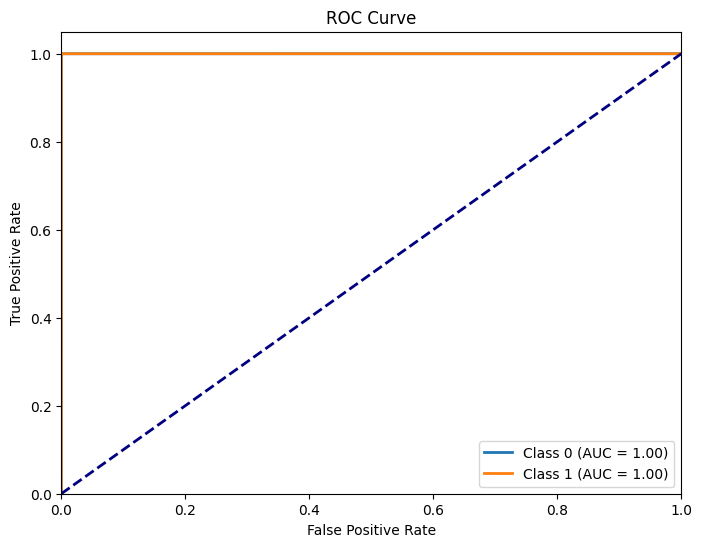

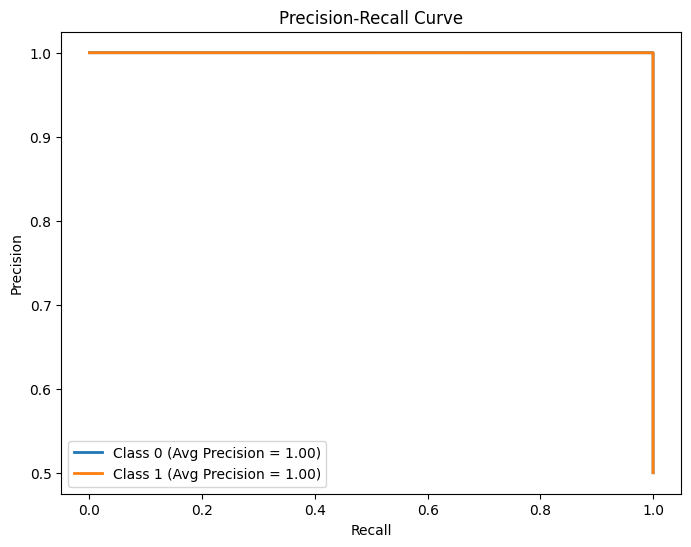

In [ ]:
print("Validation Loss: {0:.6f}".format(avg_val_loss))
print("Validation completed in {:} (h:mm:ss)".format(format_time(time.time() - t0)))


predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)
val_accuracy = np.sum(pred_labels == true_labels) / len(true_labels)

print("Validation Accuracy: {0:.6f}".format(val_accuracy))


val_f1 = f1_score(true_labels, pred_labels, average='macro')
val_precision = precision_score(true_labels, pred_labels, average='macro')
val_recall = recall_score(true_labels, pred_labels, average='macro')

print("Validation F1-Score: {0:.6f}".format(val_f1))
print("Validation Precision: {0:.6f}".format(val_precision))
print("Validation Recall: {0:.6f}".format(val_recall))

target_names = [str(i) for i in range(number_of_categories)]
val_classification_report = classification_report(true_labels, pred_labels, target_names=target_names, digits=6)
print("Validation Classification Report:")
print(val_classification_report)

def plot_roc_curve(true_labels, predictions, num_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, predictions, number_of_categories)


def plot_precision_recall_curve(true_labels, predictions, num_classes):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_labels, predictions[:, i], pos_label=i)
        average_precision[i] = average_precision_score(true_labels, predictions[:, i], pos_label=i)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (Avg Precision = {average_precision[i]:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

plot_precision_recall_curve(true_labels, predictions, number_of_categories)

Validation Confusion Matrix:
[[79126     3]
 [    2 79127]]


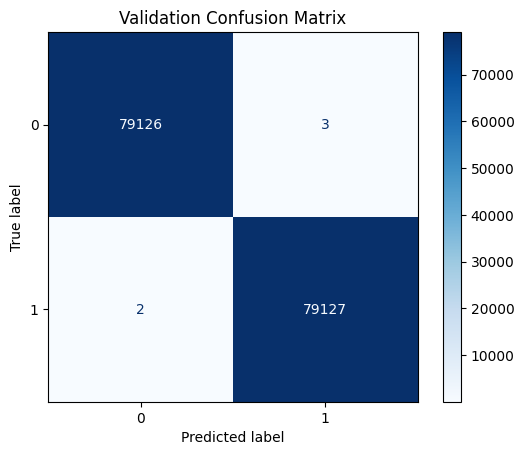

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Validation Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [ ]:

test_texts = test_df.text.values
test_labels = test_df.label.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt',
                        truncation=True,
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)


In [ ]:

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Test Loss: 0.000367
Test Accuracy: 0.999932
Test F1-Score: 0.999932
Test Precision: 0.999933
Test Recall: 0.999932
Prediction Time: 688.68 seconds


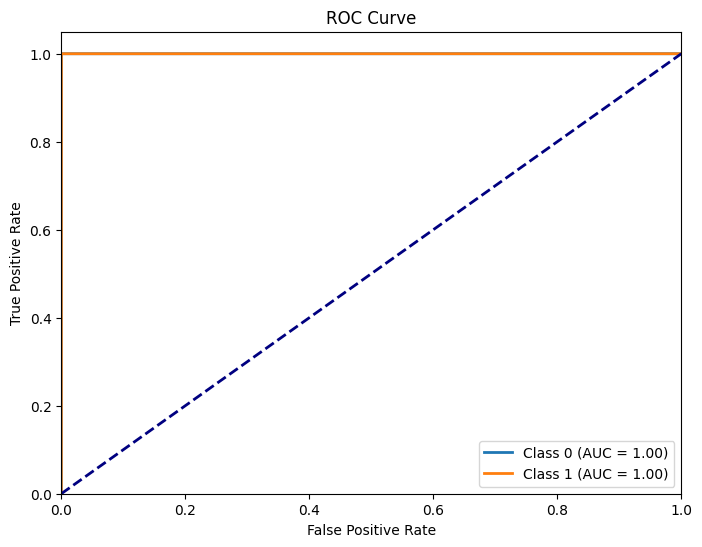

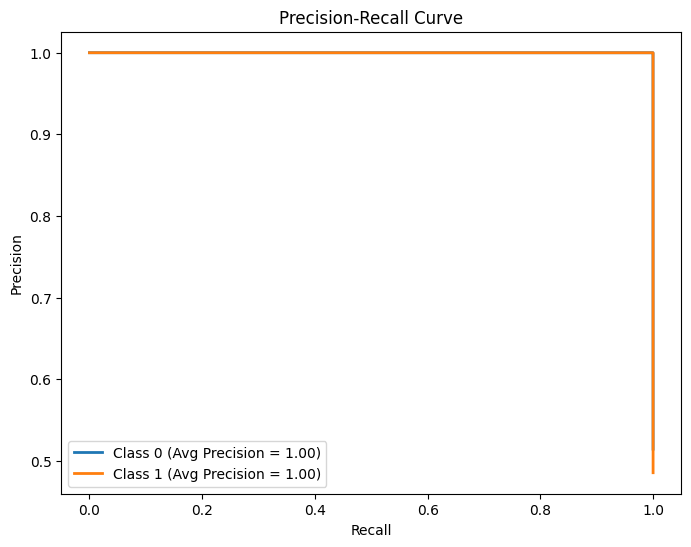

In [ ]:
import time
import torch
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import time
import torch
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score # Assurez-vous d'importer les fonctions appropriées


model.eval()

test_loss, test_accuracy = 0, 0
predictions, true_labels = [], []


start_time = time.time()

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    test_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)


end_time = time.time()
prediction_time = end_time - start_time

avg_test_loss = test_loss / len(prediction_dataloader)

print("Test Loss: {0:.6f}".format(avg_test_loss))


predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)
test_accuracy = np.sum(pred_labels == true_labels) / len(true_labels)

print("Test Accuracy: {0:.6f}".format(test_accuracy))


test_f1 = f1_score(true_labels, pred_labels, average='macro')
test_precision = precision_score(true_labels, pred_labels, average='macro')
test_recall = recall_score(true_labels, pred_labels, average='macro')

print("Test F1-Score: {0:.6f}".format(test_f1))
print("Test Precision: {0:.6f}".format(test_precision))
print("Test Recall: {0:.6f}".format(test_recall))


print("Prediction Time: {0:.2f} seconds".format(prediction_time))


plot_roc_curve(true_labels, predictions, number_of_categories)


plot_precision_recall_curve(true_labels, predictions, number_of_categories)


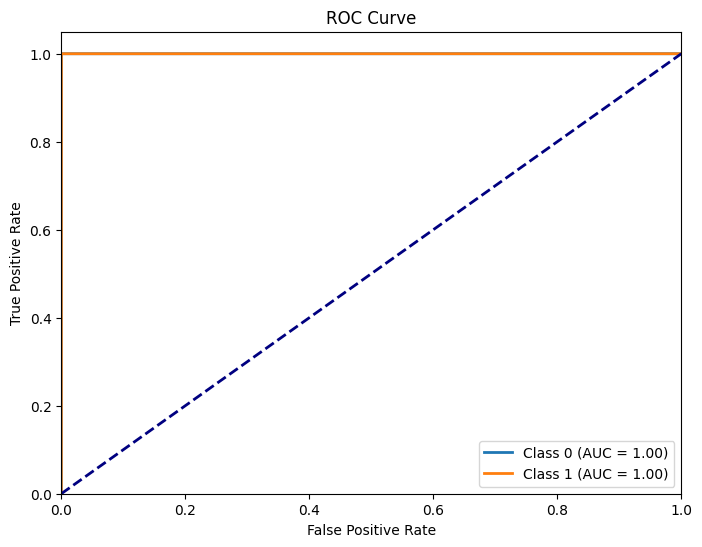

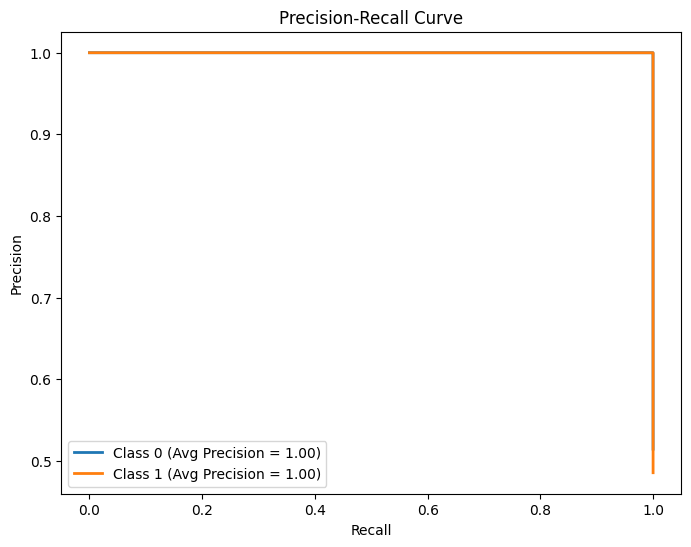

In [ ]:
# Plot ROC and AUC curves for the test data
plot_roc_curve(true_labels, predictions, number_of_categories)

# Plot Precision-Recall curves for the test data
plot_precision_recall_curve(true_labels, predictions, number_of_categories)